# L4b: Kernel Regression of Financial Time Series Data
Fill me in

## Setup, Data, and Prerequisites
We set up the computational environment by including the `Include.jl` file, loading any needed resources, such as sample datasets, and setting up any required constants. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem.

In [3]:
include("Include.jl");

### Data
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `02-07-2025`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyMarketDataSet()` function:

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];


__Clean the data__: Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow

2792

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = let

    dataset = Dict{String,DataFrame}();
    for (ticker,data) ∈ original_dataset
        if (nrow(data) == maximum_number_trading_days)
            dataset[ticker] = data;
        end
    end
    dataset
end;

Let's get a list of firms in the cleaned up `dataset` and save it in the `all_tickers` array. We sort the firms alphabetically from `A` to `Z`:

In [11]:
list_of_all_tickers = keys(dataset) |> collect |> sort;

Compute the expected (annualized) excess log growth rate by passing the `dataset` and the entire list of firms we have in the dataset to the [log_growth_matrix(...) method](src/Compute.jl). The log growth rate between time period $j-1$ to $j$, e.g., yesterday to today is defined as:
$$
\begin{equation}
\mu_{j,j-1} = \left(\frac{1}{\Delta{t}}\right)\ln\left(\frac{S_{j}}{S_{j-1}}\right)
\end{equation}
$$
where $\Delta{t}$ denotes the period time step, and $S_{j}$ denote share price in period $j$.
* The log growth rates are stored in the `D::Array{Float64,2}` variable, a $T-1\times{N}$ array of log return values. Each row of the `D` matrix corresponds to a time value, while each column corresponds to a firm

In [13]:
D = let

    # setup some constants -
    Δt = (1/252); # 1-trading day in units of years
    risk_free_rate = 0.0415; # inferred cc risk-free rate

    # compute
    μ = log_growth_matrix(dataset, list_of_all_tickers, Δt = Δt, 
        risk_free_rate = risk_free_rate);

    # return to caller
    μ
end

2791×424 Matrix{Float64}:
 -0.919054     6.23955    -2.91247    …   -0.796891    0.204394  -1.04677
  2.77476      1.02999     1.35089         2.09682    -0.84429    0.944968
  3.27155      0.814097   -0.036132        0.068377    1.1495    -2.62294
  0.604925    17.2184      1.65065         0.233216    3.1178    -0.409728
  1.77459      2.53811     3.27774         0.580177   -2.2102     4.36159
  0.57233     -4.00534    -0.83428    …   -0.904239   -1.95127   -3.15774
  2.81921     -0.525251    4.80423         1.7242     -1.81835   -1.1311
  2.00521      0.972004    1.86659         1.63447     4.40834   -0.179319
  1.27139      1.63263     0.0657592      -1.54858    -2.17846    1.39634
  1.17866      6.08807     0.891078       -1.57352     2.83634   -1.47776
 -0.479168     4.82859     0.96624    …   -0.362761    9.46677   -3.05023
  1.32131      3.57167    -2.38926         0.669113    4.48073    0.299031
 -4.78054      1.34435    -3.05774        -2.19395    -6.69057    1.36462
  ⋮      

Next, let's [z-score center](https://en.wikipedia.org/wiki/Feature_scaling) the continous feature data. In [z-score feature scaling](https://en.wikipedia.org/wiki/Feature_scaling), we subtract off the mean of each feature and then divide by the standard deviation, i.e., $x^{\prime} = (x - \mu)/\sigma$ where $x$ is the unscaled data, and $x^{\prime}$ is the scaled data. Under this scaling regime, $x^{\prime}\leq{0}$ will be values that are less than or equal to the mean value $\mu$, while $x^{\prime}>0$ indicate values that are greater than the mean.

We save the z-score centered growth data data in the `D̄::Array{Float64,2}` variable:

In [15]:
D̄ = let

    # setup -
    number_of_examples = size(D,1);

    D̄ = copy(D);
    for j ∈ eachindex(list_of_all_tickers)
        μ = mean(D[:,j]); # compute the mean
        σ = std(D[:,j]); # compute std

        # rescale -
        for k ∈ 1:number_of_examples
            D̄[k,j] = (D[k,j] - μ)/σ;
        end
    end
    
    D̄
end

2791×424 Matrix{Float64}:
 -0.270236    0.875241   -0.51285    …  -0.172603    0.0340086  -0.326599
  0.735235    0.153683    0.270667       0.365351   -0.156963    0.235764
  0.870466    0.123779    0.0157621     -0.0117454   0.206118   -0.771629
  0.144598    2.39589     0.325758       0.018899    0.564557   -0.146732
  0.462985    0.362567    0.624783       0.0834006  -0.405704    1.20044
  0.135725   -0.543745   -0.130921   …  -0.192559   -0.35855    -0.922629
  0.747335   -0.0617295   0.905321       0.29608    -0.334345   -0.35041
  0.52576     0.145651    0.365443       0.279399    0.799572   -0.0816769
  0.326013    0.237151    0.0344876     -0.312346   -0.399924    0.363208
  0.30077     0.854261    0.186164      -0.316981    0.513302   -0.448288
 -0.150497    0.679814    0.199977   …  -0.0918959   1.72074    -0.892273
  0.339601    0.505721   -0.416694       0.0999343   0.812754    0.0533844
 -1.32135     0.197223   -0.539546      -0.432322   -1.22161     0.354251
  ⋮         

## Theory: Kernel Regression
Suppose we have a dataset $\mathcal{D} = \{(\mathbf{x}_{i},y_{i}) \mid i = 1,2,\dots,n\}$, where the features $\mathbf{x}_i \in \mathbb{R}^{m}$ are $m$-dimensional vectors ($m\ll{n}$) and the target variables are continuous values $y_i \in \mathbb{R}$, e.g., the price of a house, the price of a stock, the temperature, etc. We can model this as a linear regression problem:
$$
\hat{\mathbf{y}} = \hat{\mathbf{X}}\theta
$$
where $\hat{\mathbf{X}}$ is a data matrix with the transpose of the augmented feature vectors $\hat{\mathbf{x}}^{\top}$ on the rows, and $\theta$ is an unknown parameter vector $\theta\in\mathbb{R}^{p}$ where $p = m+1$. The (regularized) least squares solution for the parameters $\theta$ is given by:
$$
\begin{equation}
\hat{\mathbf{\theta}}_{\lambda} = \left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}}+\lambda\,\mathbf{I}\right)^{-1}\hat{\mathbf{X}}^{\top}\mathbf{y}
\end{equation}
$$

#### Kernel ridge regression
The basic idea of kernel regression is to rewrite the parameter vector $\hat{\theta}_{\lambda}$ as a sum of the _augmented feature variables_: $\hat{\theta}_{\lambda} \equiv \sum_{i=1}^{n}\alpha_{i}\hat{\mathbf{x}}_{i}$. Then for some (new) feature vector $\hat{\mathbf{z}}$,  the predicted output $\hat{y}$ is given by:
$$
\begin{align}
\hat{y} & = \hat{\mathbf{z}}^{\top}\theta = \sum_{i=1}^{n}\alpha_{i}\left<\hat{\mathbf{z}},\mathbf{x}_{i}\right>\quad\mid\text{\,Replace inner product with kernel}\\
        & = \hat{\mathbf{z}}^{\top}\theta \simeq \sum_{i=1}^{n}\alpha_{i}\,k(\hat{\mathbf{z}},\mathbf{x}_{i})
\end{align}
$$
where $k(\hat{\mathbf{z}},\mathbf{x}_{i})$ denotes a kernel function (similarity score) between a new (augmented) feature vector and $\hat{\mathbf{z}}$ and the (known) training feature vector $\hat{\mathbf{x}}_{i}$. We need to estimate the $\alpha_{i}$ parameters; however, this is not as hard as it may first appear.

__How are $\alpha$ and $\theta$ related__? 
The two expression for $\hat{\theta}_{\lambda}$ can be equated:
$$
\begin{equation}
\left(\hat{\mathbf{X}}^{\top}\hat{\mathbf{X}}+\lambda\,\mathbf{I}\right)^{-1}\hat{\mathbf{X}}^{\top}\mathbf{y} = \hat{\mathbf{X}}^{\top}\alpha
\end{equation}
$$
After some algebraic manipulation that [is shown in the course notes](https://github.com/varnerlab/CHEME-5820-Lectures-Spring-2025/blob/main/lectures/week-4/L4a/docs/Notes.pdf), this expression can be solved for the expansion coefficients:
$$
\begin{equation}
\alpha = \left(\mathbf{K}^{\prime}+\lambda\mathbf{I}\right)^{-1}\mathbf{y}
\end{equation}
$$
where $\mathbf{K}^{\prime} = \hat{\mathbf{X}}\hat{\mathbf{X}}^{\top}$, the matrix $\mathbf{I}$ denotes the identity matrix, the vector $\mathbf{y}$ denotes the observed outputs and $\lambda\geq{0}$ denotes the regularization parameter. 

## Task 1: Something goes here
Fill me in

In [67]:
ticker_to_model = "SPY";
window_number_of_trading_days = 100;
time_index_start = maximum_number_trading_days - window_number_of_trading_days;
time_index_end = maximum_number_trading_days - 1;

Visualize

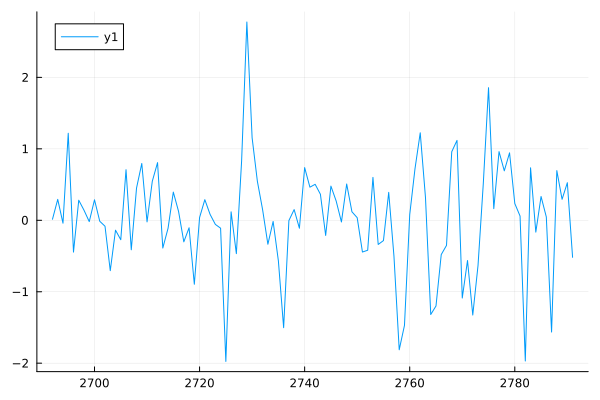

In [69]:
let
    j = findfirst(s-> s == ticker_to_model, list_of_all_tickers); # index of ticker
    î = range(time_index_start, stop=time_index_end, step=1) |> collect;

    X = zeros(window_number_of_trading_days,2);
    for k ∈ eachindex(î)
        timeindex = î[k] |> Int;
        X[k,1] = timeindex;
        X[k,2] = D̄[timeindex,j];
    end
    plot(X[:,1], X[:,2])
end

## Task 2: Kernel Regression of a Tikcer in terms of `SPY`
Fill me in

## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.